# CS 251/340 Machine Learning Final Project

# Authors: Aram Abrahamyan & Areg Vardanyan

# Instructor: Davit Ghazaryan

# Topic: Music Genre Recognition

---

### Importing the necessary libraries

In [61]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')

### Reading the data

The GTZAN dataset provides 2 csv files. One contains features extracted from first 30 seconds of a WAV file; however, contains just 1000 data points. The other one contains features extracted from first 3 seconds of the same WAV files and contains 9990 data points. Firstly, we have tried to use the small dataset, thinking that in the tradeoff between more information/less data and less information/more data the first variant would be more preferrable, but it was not the case, so we moved forward with the larger dataset.

In [44]:
df = pd.read_csv('GTZAN/Data/features_3_sec.csv')

There are 10 unique classes in the dataset

In [48]:
f'Number of unique classes: {len(df.label.unique())}'

'Number of unique classes: 10'

And they are equally distributed, so there is no class imbalance.

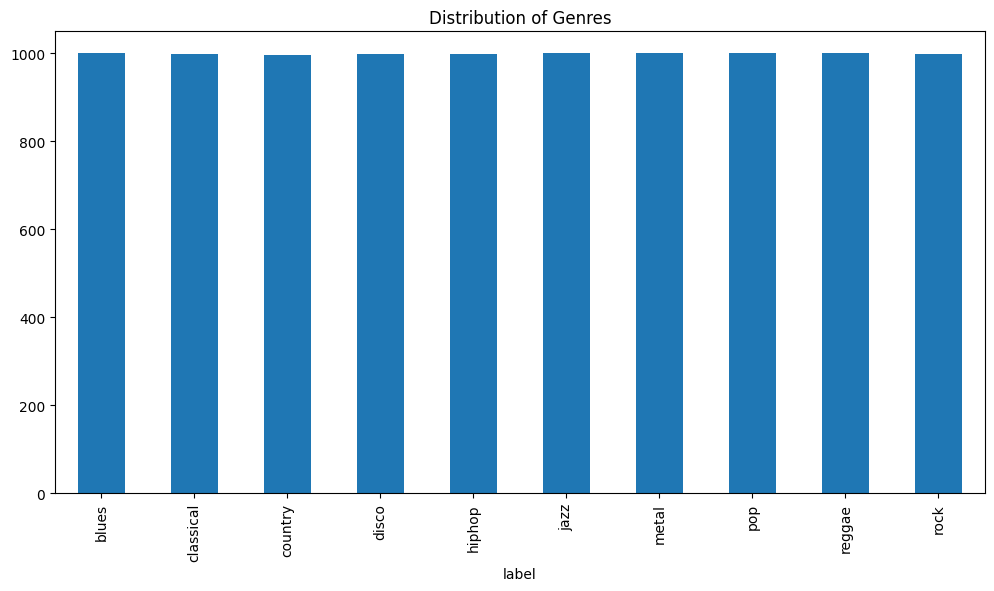

In [49]:
df['label'].groupby(df['label']).count().plot(kind='bar', figsize=(12, 6), title='Distribution of Genres');

### Defining a function to further assess the implemented algorithms

As the default function for getting all metrics for given model from sci-kit learn was a bit confusing for us, we have decided to define a function ourselves that will get the metrics(accuracy, precision, recall, f1) as well as the confusion matrix and return them.

In [ ]:
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['label'].unique())
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nConfusion Matrix:')

### Separating the features and labelest from the DataFrame

Further we separate the labels from the DataFrame and do the train/test split.

In [51]:
X = df.iloc[:, 2:-1].values  # Features
y = df["label"].values  # Genre labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Normalizing (Z-score normalization) the features

For the next step we use the StandardScaler function from sci-kit learn to scale the features.

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Afterwards, we decided to run our first classifier, which is RandomForest, and look at the initial result.

---

## Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

Metrics for Random Forest:
Accuracy: 0.8663663663663663
Precision: 0.8681393701719409
Recall: 0.8663663663663663
F1: 0.865758907477053
Confusion Matrix:


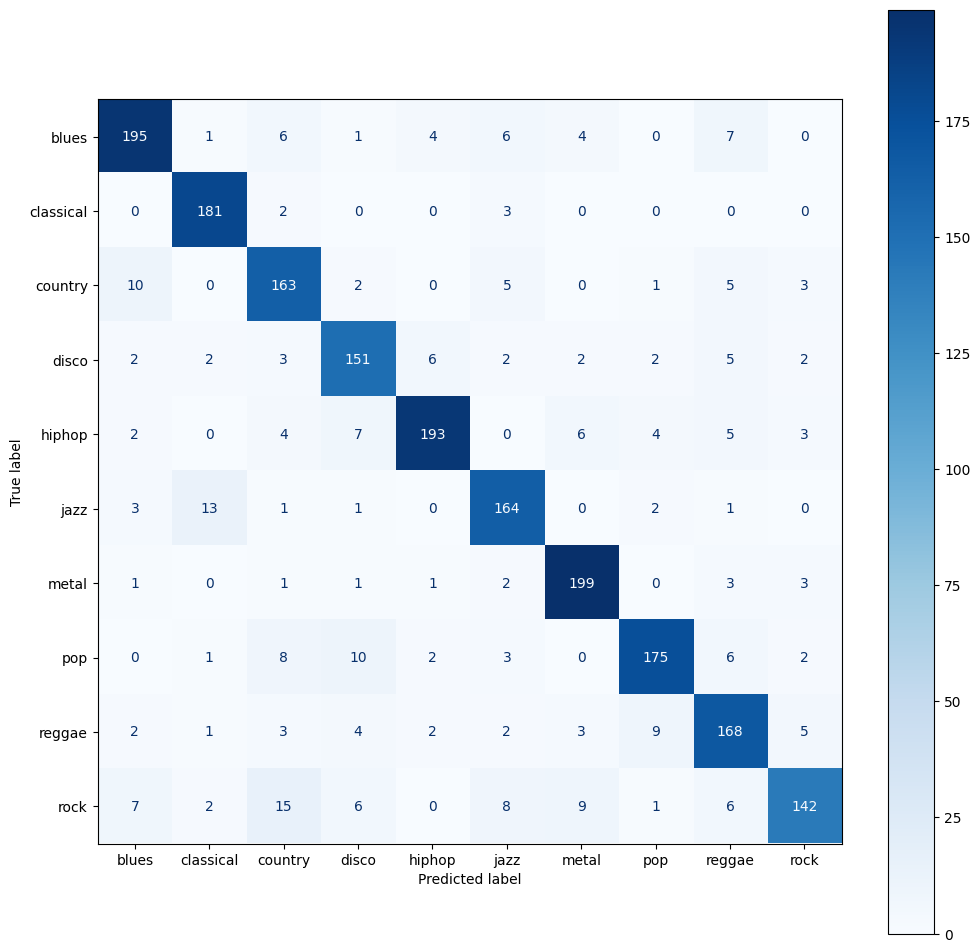

In [56]:
rf_pred = rf.predict(X_test_scaled)
print(f'Metrics for Random Forest:\n{get_metrics(y_test, rf_pred)}')

The result is pretty good; however, we can further improve it using GridSearchCV to get the best parameters according to F1 score for Random Forest using cross validation techniques.

In [57]:
gs_rf = GridSearchCV(estimator=rf, param_grid={
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}, scoring='f1_macro', cv=3)
gs_rf.fit(X_train, y_train)
gs_rf.best_params_

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Let's run Random Forest with the given parameters, and see what happens

In [62]:
rf_bp = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100)
rf_bp.fit(X_train_scaled, y_train)

RandomForestClassifier()

Metrics for Random Forest:
Accuracy: 0.8648648648648649
Precision: 0.8679406565773959
Recall: 0.8648648648648649
F1: 0.8643155933919525
Confusion Matrix:


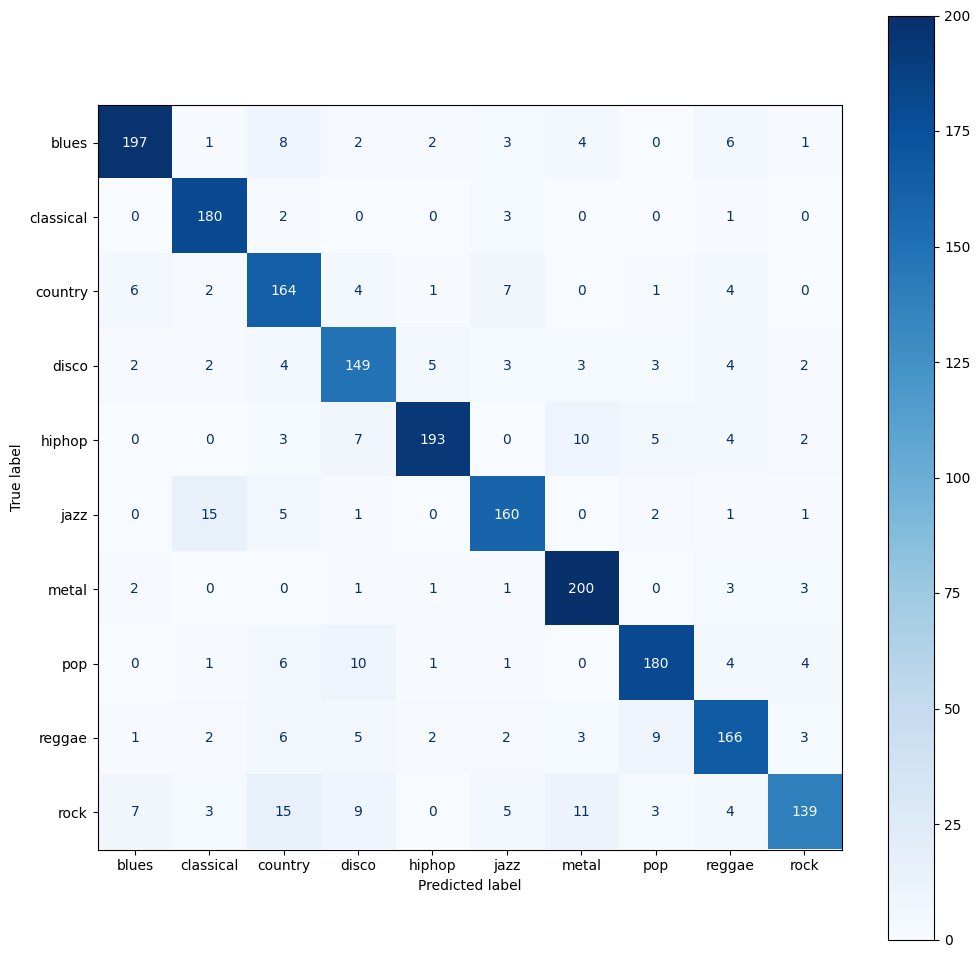

In [63]:
rf_bp_pred = rf_bp.predict(X_test_scaled)
print(f'Metrics for Random Forest:\n{get_metrics(y_test, rf_bp_pred)}')

The result got slightly better, but we can have a look at feature importance and further enhance our model.

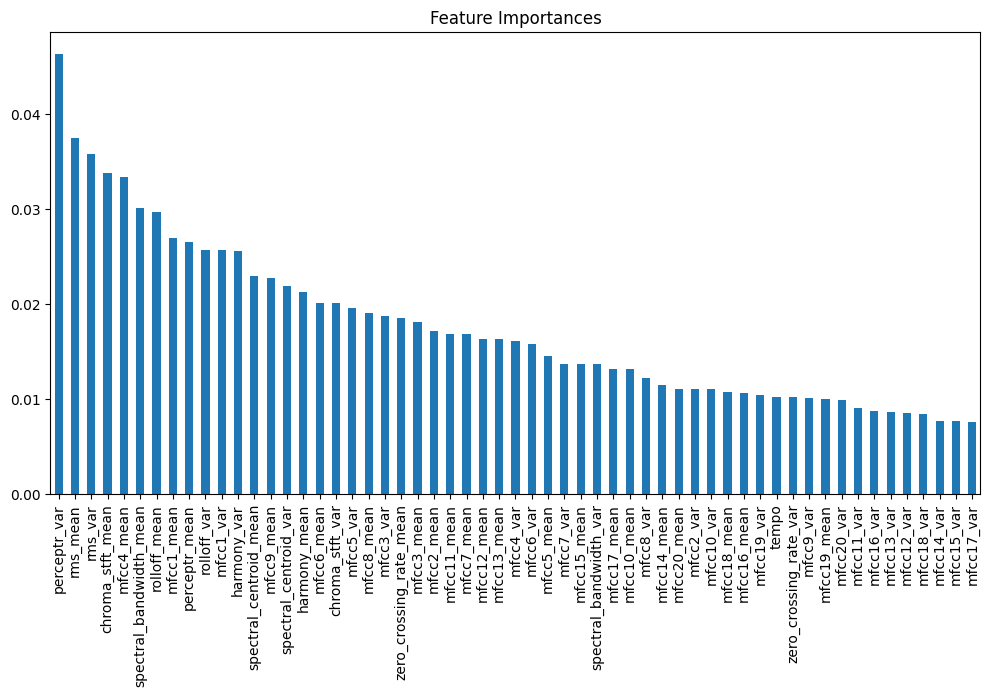

In [64]:
feature_importances = pd.Series(rf_bp.feature_importances_, index=df.columns[2:-1])
feature_importances.sort_values(ascending=False, inplace=True)
feature_importances.plot(kind='bar', figsize=(12, 6), title='Feature Importances');

Let's drop all the features under 0.01 and run the model again.

Metrics for Random Forest:
Accuracy: 0.8693693693693694
Precision: 0.8711775598045051
Recall: 0.8693693693693694
F1: 0.8691385553745784
Confusion Matrix:


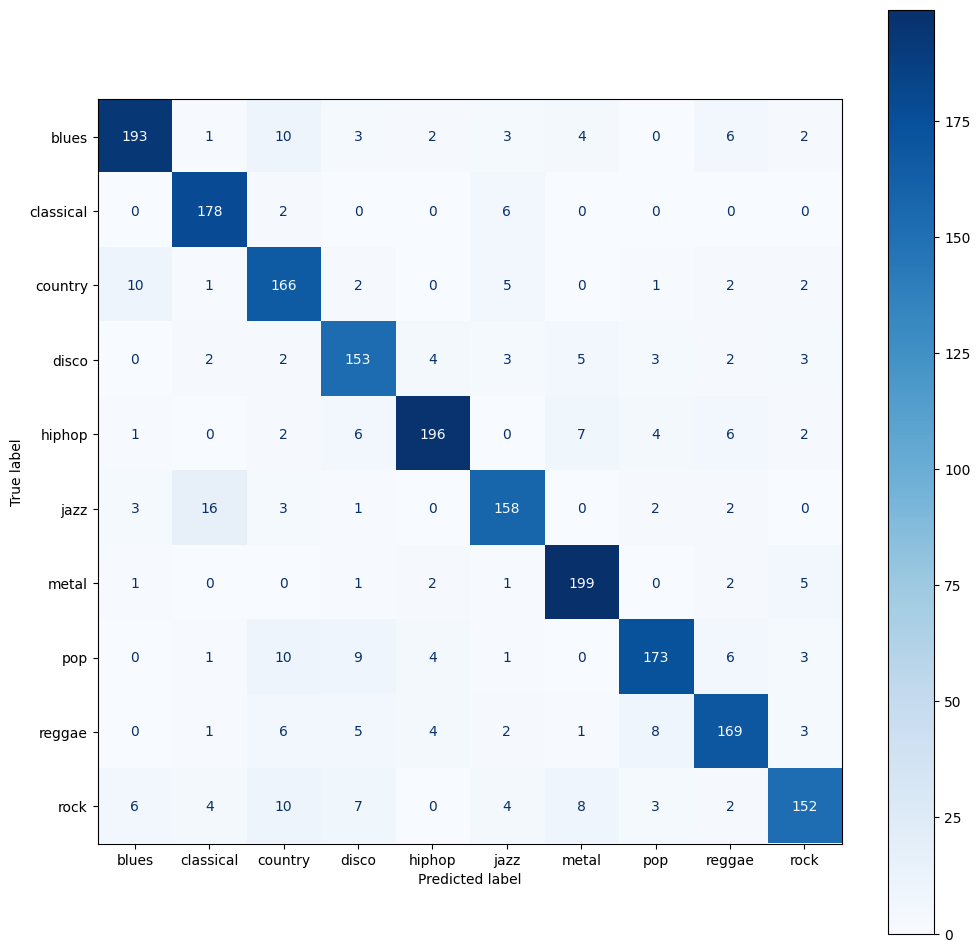

In [66]:
selector = SelectFromModel(rf_bp, threshold=0.01, prefit=True)
X_train_sr = selector.transform(X_train_scaled)
X_test_sr = selector.transform(X_test_scaled)
rf_reduced = RandomForestClassifier()
rf_reduced.fit(X_train_sr, y_train)
rf_reduced_pred = rf_reduced.predict(X_test_sr)
print(f'Metrics for Random Forest:\n{get_metrics(y_test, rf_reduced_pred)}')

The result got slightly better, so we have decided to keep going with the reduced features. X_train_sr stands for X_train scaled and reduced, the same works for X_test_sr

---

## kNN

In the same manner first we will look at the results of kNN with default parameters then run a GridSearchCV to get the best parameters.

Metrics for kNN:
Accuracy: 0.8948948948948949
Precision: 0.8981059740034674
Recall: 0.8948948948948949
F1: 0.8953844542497543
Confusion Matrix:


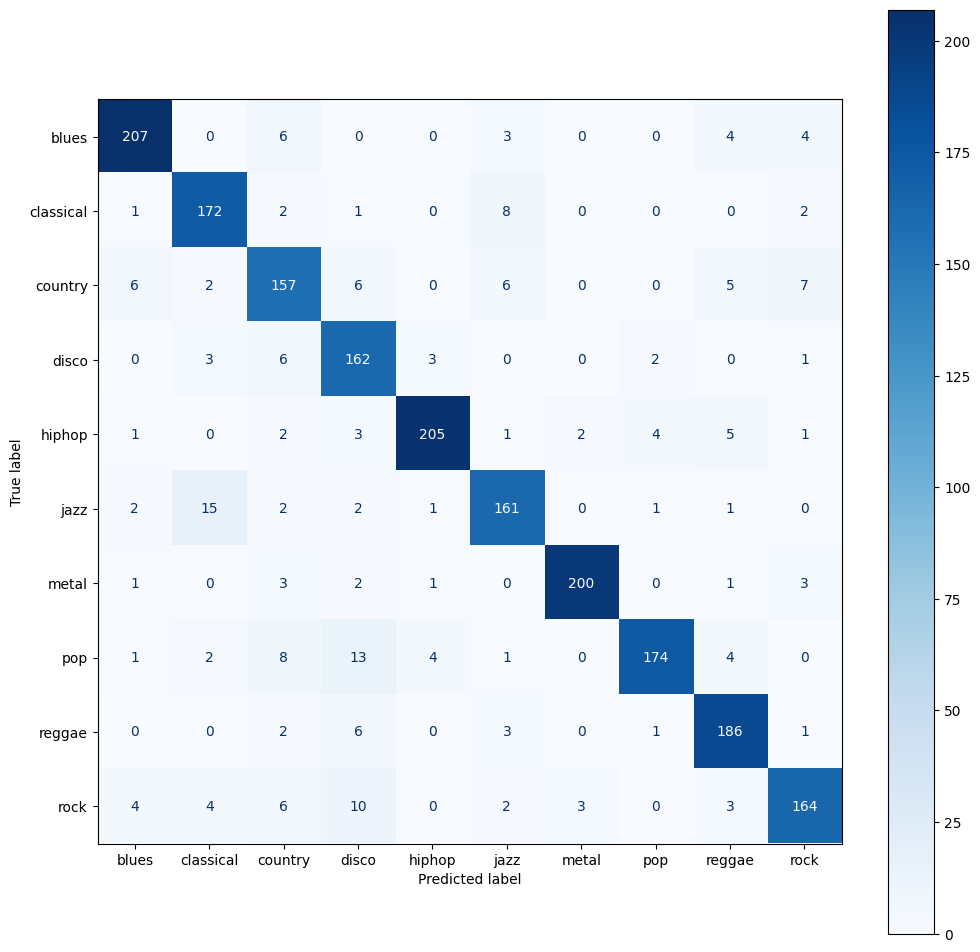

In [67]:
knn = KNeighborsClassifier()
knn.fit(X_train_sr, y_train)
knn_pred = knn.predict(X_test_sr)
print(f'Metrics for kNN:\n{get_metrics(y_test, knn_pred)}')

## Cross Validation for kNN

In [69]:
gs_knn = GridSearchCV(estimator=knn, param_grid={
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['distance'],
    'p': [1, 2]
}, scoring='f1_macro', cv=3)
gs_knn.fit(X_train_sr, y_train)
gs_knn.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

## kNN with the best parameters

Metrics for kNN:
Accuracy: 0.8948948948948949
Precision: 0.8981059740034674
Recall: 0.8948948948948949
F1: 0.8953844542497543
Confusion Matrix:


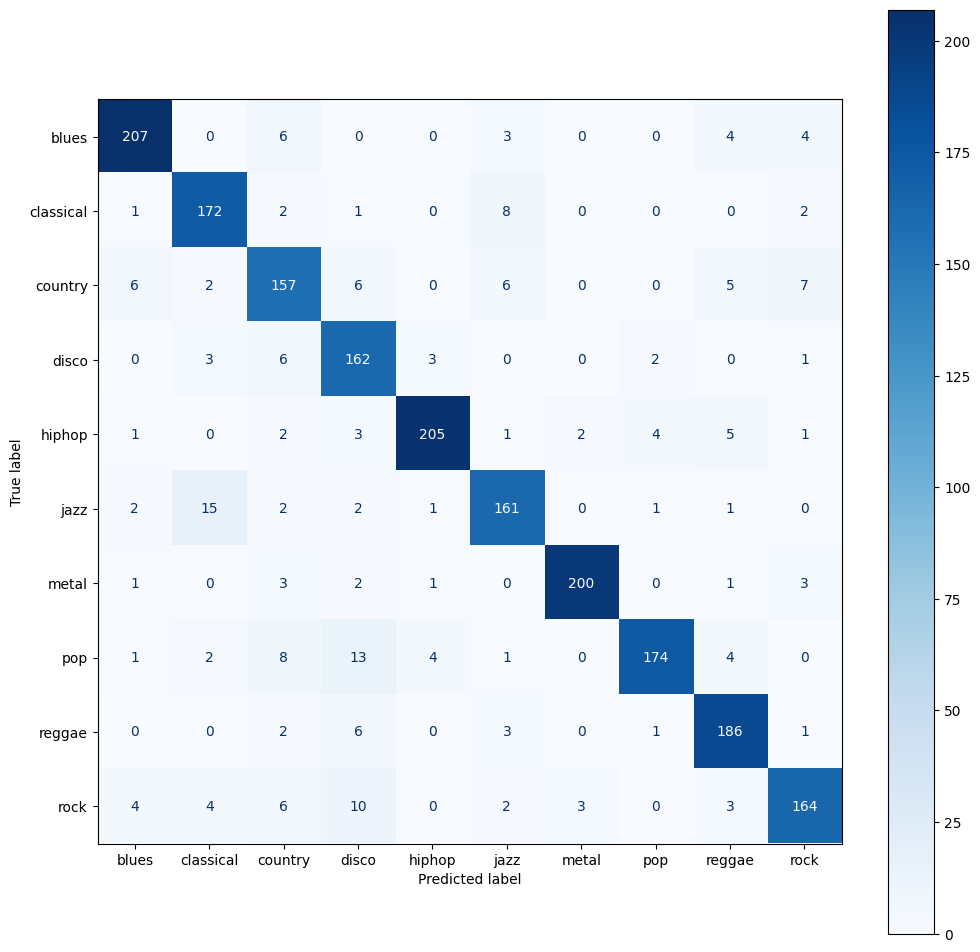

In [70]:
knn_bp = KNeighborsClassifier(n_neighbors=3, weights='distance', p=1)
knn_bp.fit(X_train_sr, y_train)
knn_bp_pred = knn.predict(X_test_sr)
print(f'Metrics for kNN:\n{get_metrics(y_test, knn_bp_pred)}')

---

## Gaussian Naive Bayes

Metrics for Gaussian Naive Bayes:
Accuracy: 0.509009009009009
Precision: 0.5238004236979701
Recall: 0.509009009009009
F1: 0.4859289383112819
Confusion Matrix:


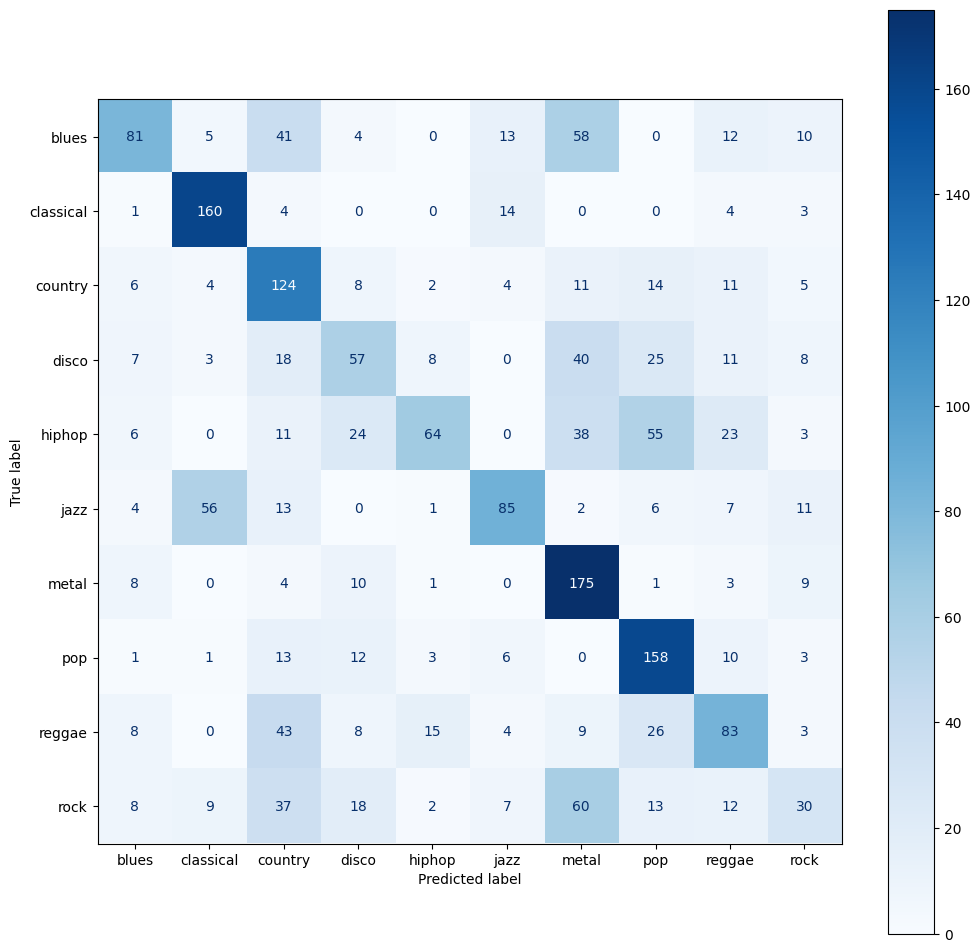

In [71]:
gnb = GaussianNB()
gnb.fit(X_train_sr, y_train)
gnb_pred = gnb.predict(X_test_sr)
print(f'Metrics for Gaussian Naive Bayes:\n{get_metrics(y_test, gnb_pred)}')

---

## Logistics Regression

Metrics for Logistic Regression:
Accuracy: 0.7077077077077077
Precision: 0.7066428623096533
Recall: 0.7077077077077077
F1: 0.7067122096077376
Confusion Matrix:


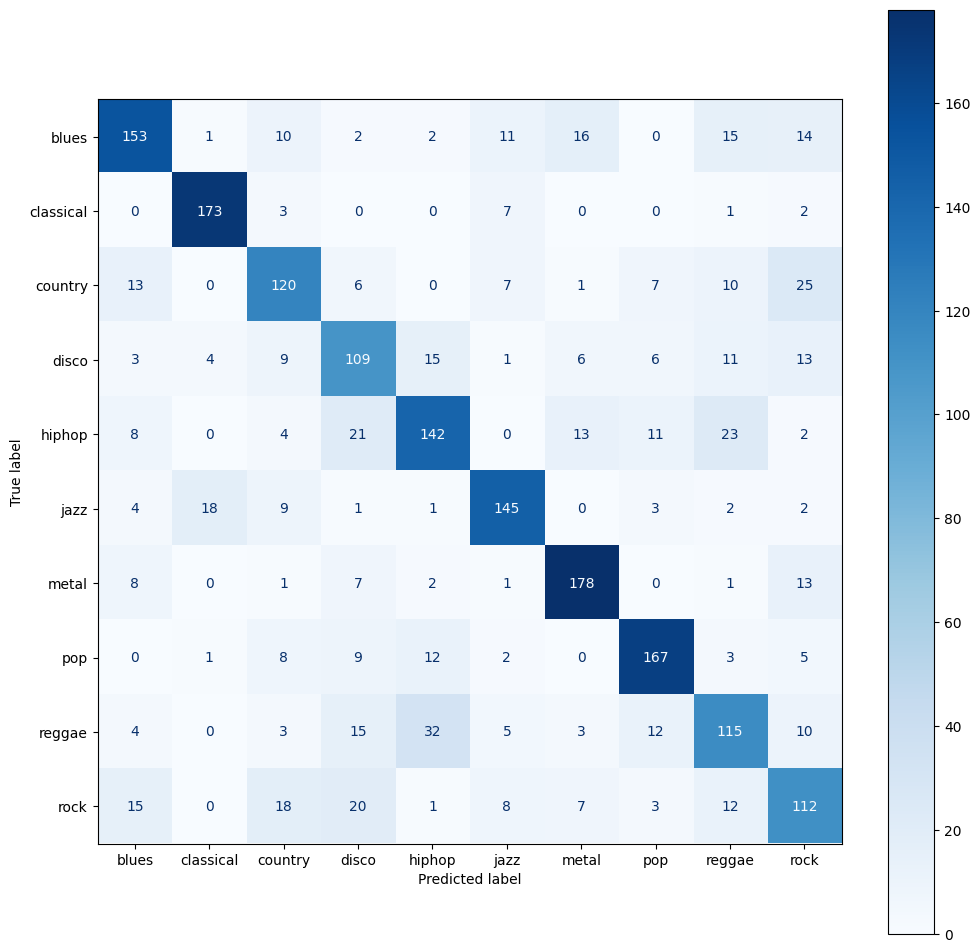

In [72]:
lr = LogisticRegression()
lr.fit(X_train_sr, y_train)
lr_pred = lr.predict(X_test_sr)
print(f'Metrics for Logistic Regression:\n{get_metrics(y_test, lr_pred)}')

In [74]:
gs_lr = GridSearchCV(estimator=lr, param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
}, scoring='f1_macro', cv=5)
gs_lr.fit(X_train_sr, y_train)
gs_lr.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Metrics for Logistic Regression:
Accuracy: 0.7077077077077077
Precision: 0.7066428623096533
Recall: 0.7077077077077077
F1: 0.7067122096077376
Confusion Matrix:


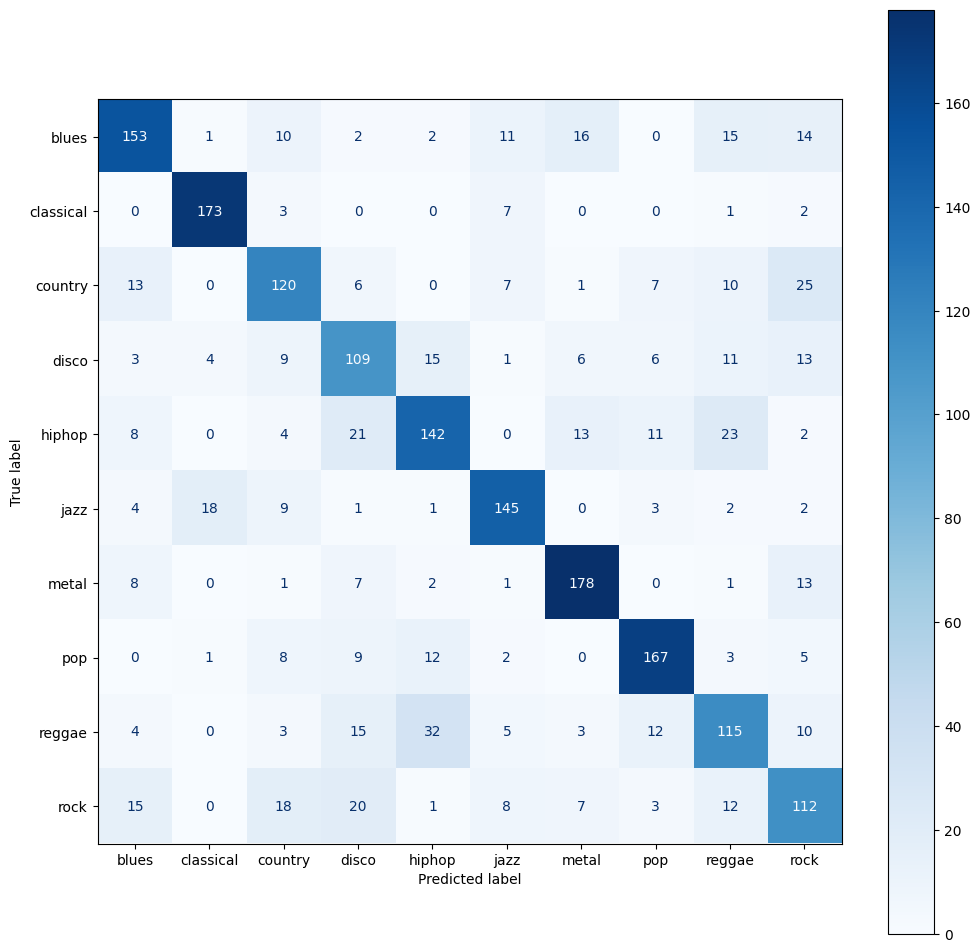

In [75]:
lr_bp = LogisticRegression(C=10, penalty='l1', solver='liblinear')
lr.fit(X_train_sr, y_train)
lr_bp_pred = lr.predict(X_test_sr)
print(f'Metrics for Logistic Regression:\n{get_metrics(y_test, lr_bp_pred)}')

---

## SVM

Metrics for SVM:
Accuracy: 0.8728728728728729
Precision: 0.8751065457355525
Recall: 0.8728728728728729
F1: 0.8732590634160865
Confusion Matrix:


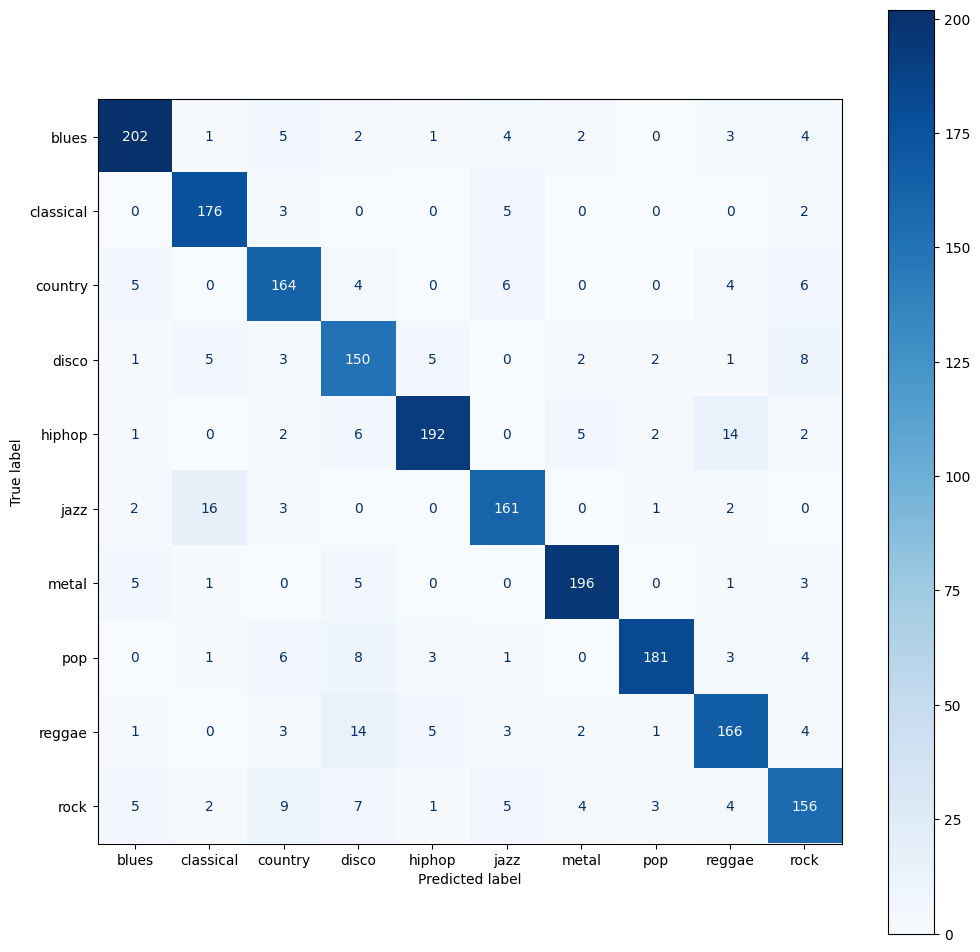

In [76]:
svm = SVC()
svm.fit(X_train_sr, y_train)
svm_pred = svm.predict(X_test_sr)
print(f'Metrics for SVM:\n{get_metrics(y_test, svm_pred)}')

In [79]:
# 1. For linear kernel (no gamma, no degree)
param_grid_linear = {
    'C': range(1, 100, 10),
    'kernel': ['linear'],
}

# 2. For rbf/sigmoid kernels (with gamma)
param_grid_rbf_sigmoid = {
    'C': range(1, 100, 10),
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

# 3. For poly kernel (with gamma and degree)
param_grid_poly = {
    'C': range(1, 100, 10),
    'kernel': ['poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
}

# Combine all grids
full_param_grid = [param_grid_linear, param_grid_rbf_sigmoid, param_grid_poly]

gs_svm = GridSearchCV(
    estimator=svm,
    param_grid=full_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)
gs_svm.fit(X_train_sr, y_train)
gs_svm.best_params_

Fitting 3 folds for each of 110 candidates, totalling 330 fits
[CV] END .................................C=1, kernel=linear; total time=   1.2s
[CV] END .................................C=1, kernel=linear; total time=   1.3s
[CV] END .................................C=1, kernel=linear; total time=   1.4s
[CV] END ................................C=11, kernel=linear; total time=   5.4s
[CV] END ................................C=11, kernel=linear; total time=   5.5s
[CV] END ................................C=11, kernel=linear; total time=   6.2s
[CV] END ................................C=21, kernel=linear; total time=   9.6s
[CV] END ................................C=21, kernel=linear; total time=  10.8s
[CV] END ................................C=21, kernel=linear; total time=  11.5s
[CV] END ................................C=31, kernel=linear; total time=  13.9s
[CV] END ................................C=31, kernel=linear; total time=  14.9s
[CV] END ................................C=31,

{'C': 21, 'gamma': 'auto', 'kernel': 'rbf'}

Metrics for SVM:
Accuracy: 0.9294294294294294
Precision: 0.930634387902859
Recall: 0.9294294294294294
F1: 0.9296954194749728
Confusion Matrix:


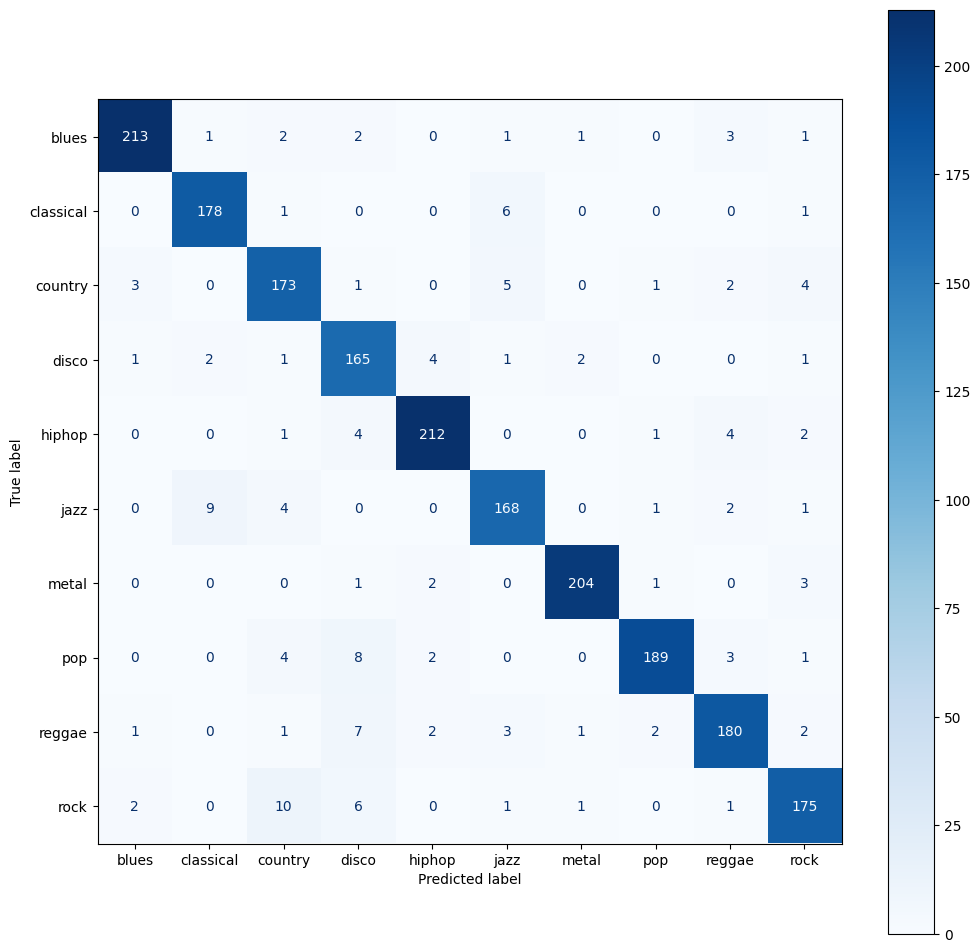

In [80]:
svm_bp = SVC(C=21, gamma='auto', kernel='rbf')
svm_bp.fit(X_train_sr, y_train)
svm_bp_pred = svm_bp.predict(X_test_sr)
print(f'Metrics for SVM:\n{get_metrics(y_test, svm_bp_pred)}')

---

## LDA

Metrics for LDA:
 Accuracy: 0.6536536536536537
Precision: 0.6614606062112718
Recall: 0.6536536536536537
F1: 0.6543580498785151
Confusion Matrix:


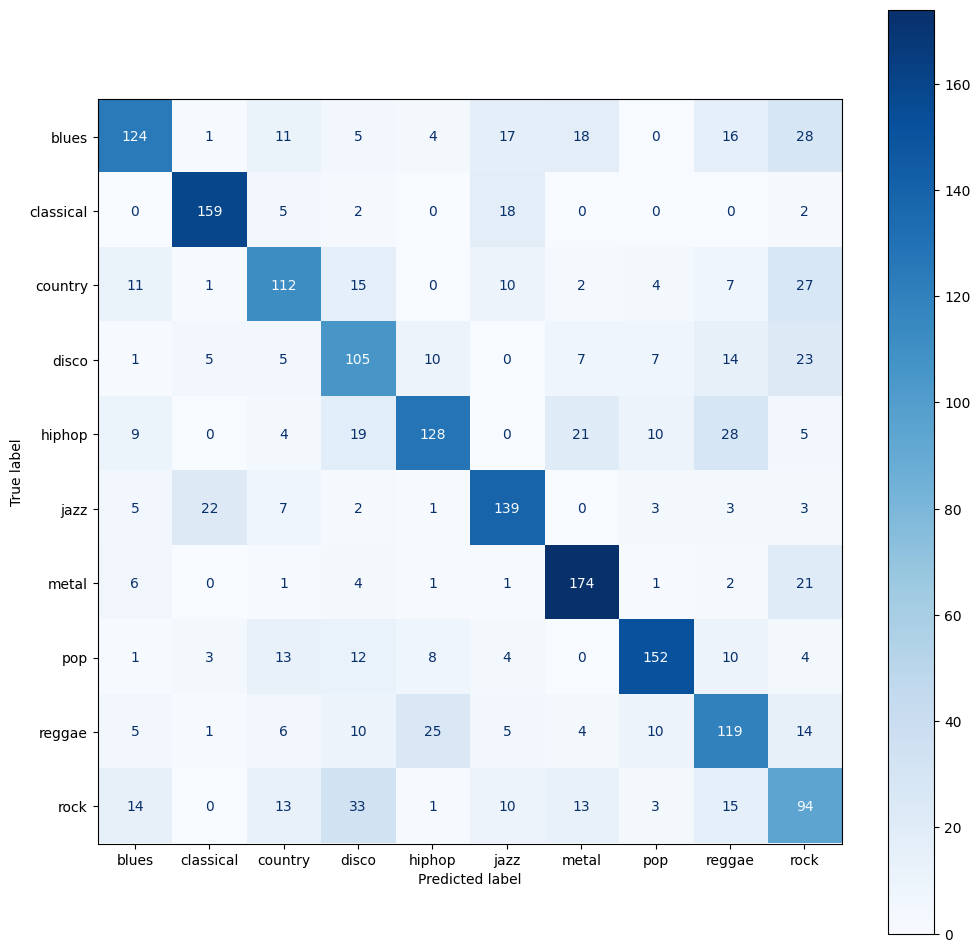

In [ ]:
lda = LDA()
lda.fit(X_train_sr, y_train)
lda_pred = lda.predict(X_test_sr)
print(f'Metrics for LDA:\n{get_metrics(y_test, lda_pred)}')

In [84]:
gs_lda = GridSearchCV(estimator=lda, param_grid={
    'solver': ['lsqr', 'eigen', 'svd'],
    'shrinkage': ['auto', 0.0, 0.2, 0.5, 0.8, 1.0],
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}, scoring='f1_macro', cv=5)
gs_lda.fit(X_train_sr, y_train)
gs_lda.best_params_

{'n_components': 1, 'shrinkage': 0.0, 'solver': 'lsqr'}

Metrics for LDA:
 Accuracy: 0.6536536536536537
Precision: 0.6614606062112718
Recall: 0.6536536536536537
F1: 0.6543580498785151
Confusion Matrix:


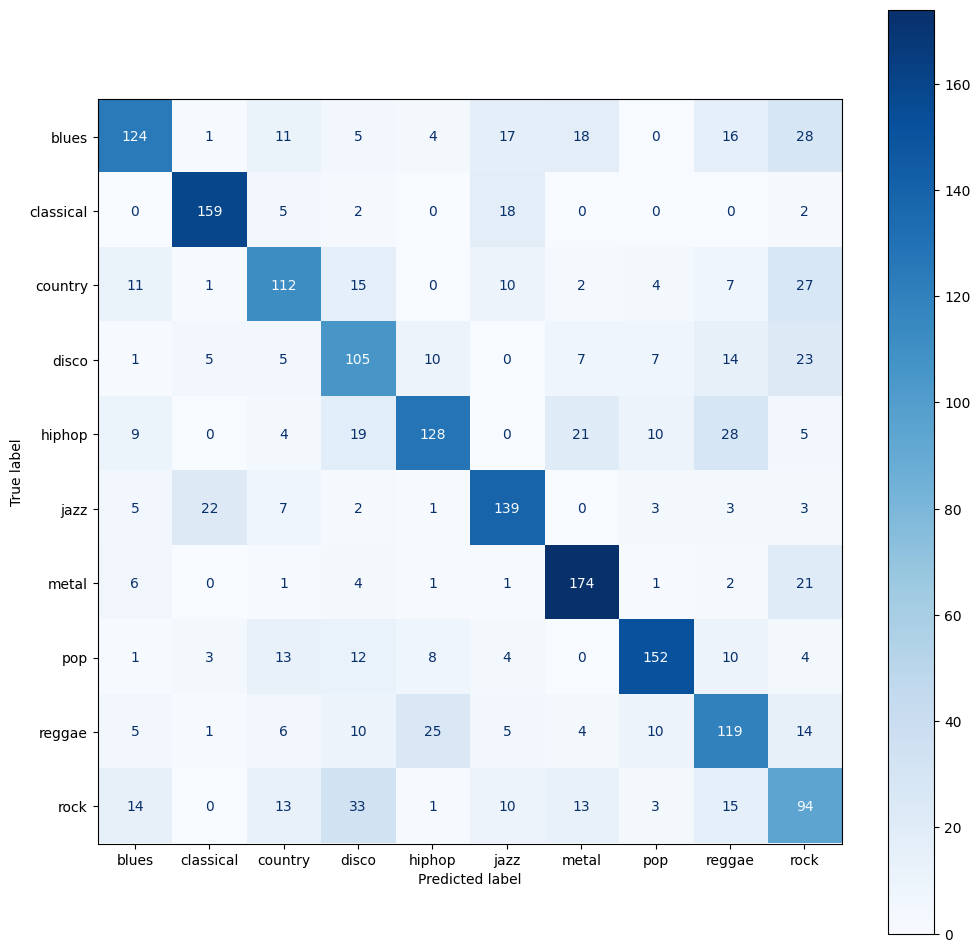

In [ ]:
lda_bp = LDA(shrinkage=0.0, solver='lsqr', n_components=1)
lda_bp.fit(X_train_sr, y_train)
lda_bp_pred = lda.predict(X_test_sr)
print(f'Metrics for LDA:\n{get_metrics(y_test, lda_bp_pred)}')

---

## QDA

Metrics for QDA:
 Accuracy: 0.7622622622622622
Precision: 0.7735970728067383
Recall: 0.7622622622622622
F1: 0.76184456143407
Confusion Matrix:


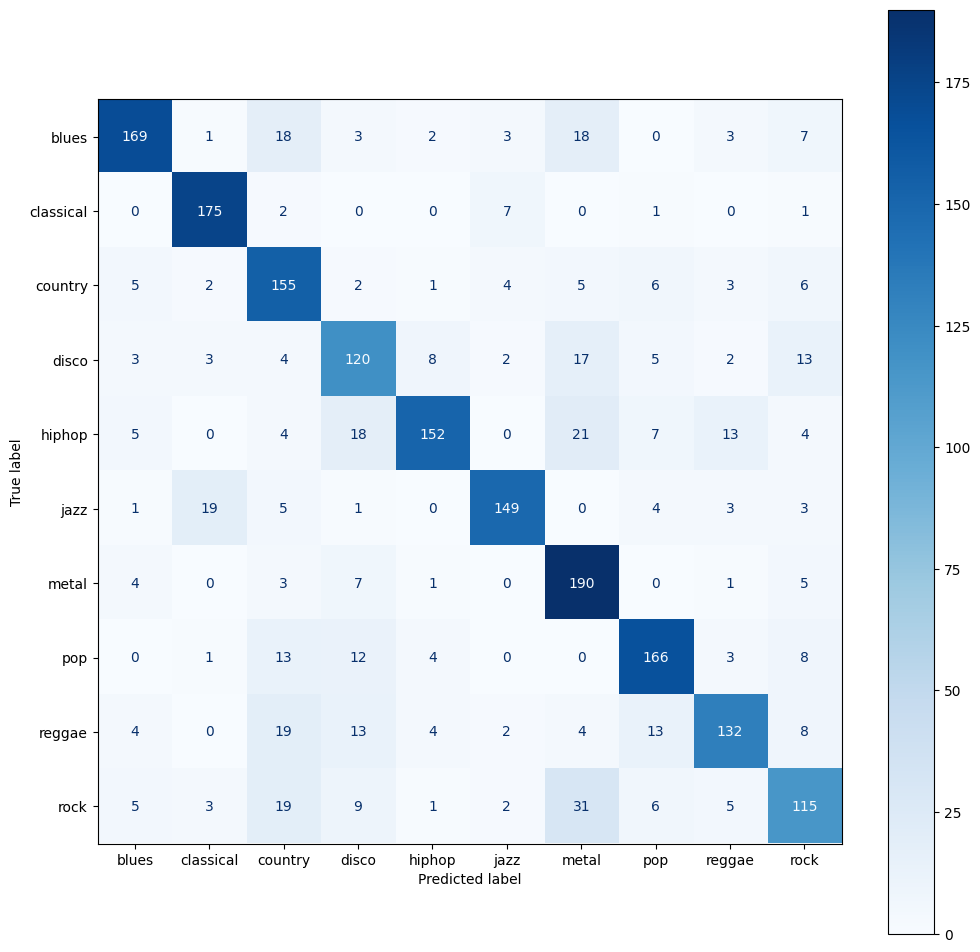

In [91]:
qda = QDA()
qda.fit(X_train_sr, y_train)
qda_pred = qda.predict(X_test_sr)
print(f'Metrics for QDA:\n {get_metrics(y_test, qda_pred)}')

In [92]:
gs_qda = GridSearchCV(estimator=qda, param_grid={
    'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}, scoring='f1_macro', cv=3)
gs_qda.fit(X_train_sr, y_train)
gs_qda.best_params_

{'reg_param': 0.0}

Metrics for QDA:
Accuracy: 0.7622622622622622
Precision: 0.7735970728067383
Recall: 0.7622622622622622
F1: 0.76184456143407
Confusion Matrix:


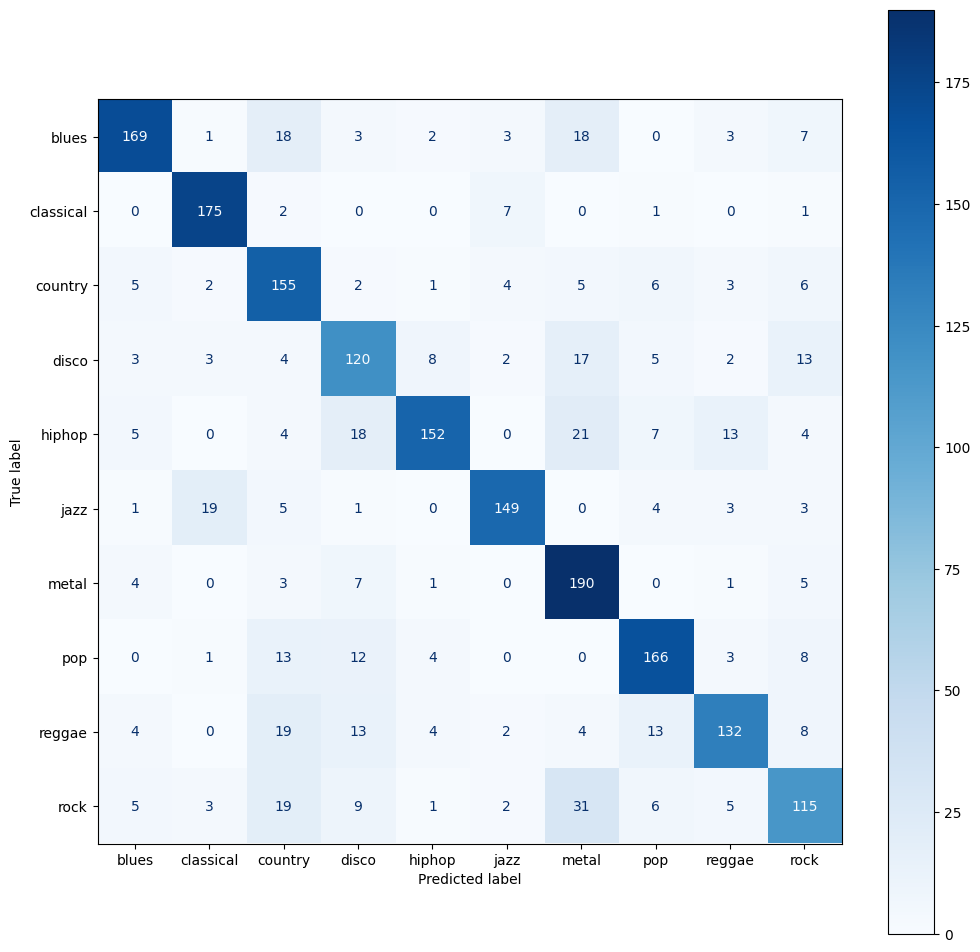

In [104]:
qda_bp = QDA(reg_param=0.0)
qda_bp.fit(X_train_sr, y_train)
qda_bp_pred = qda_bp.predict(X_test_sr)
print(f'Metrics for QDA:\n{get_metrics(y_test, qda_bp_pred)}')

Metrics for HistGradientBoostingClassifier:
Accuracy: 0.9049049049049049
Precision: 0.9057525993914647
Recall: 0.9049049049049049
F1: 0.904923964136259
Confusion Matrix:


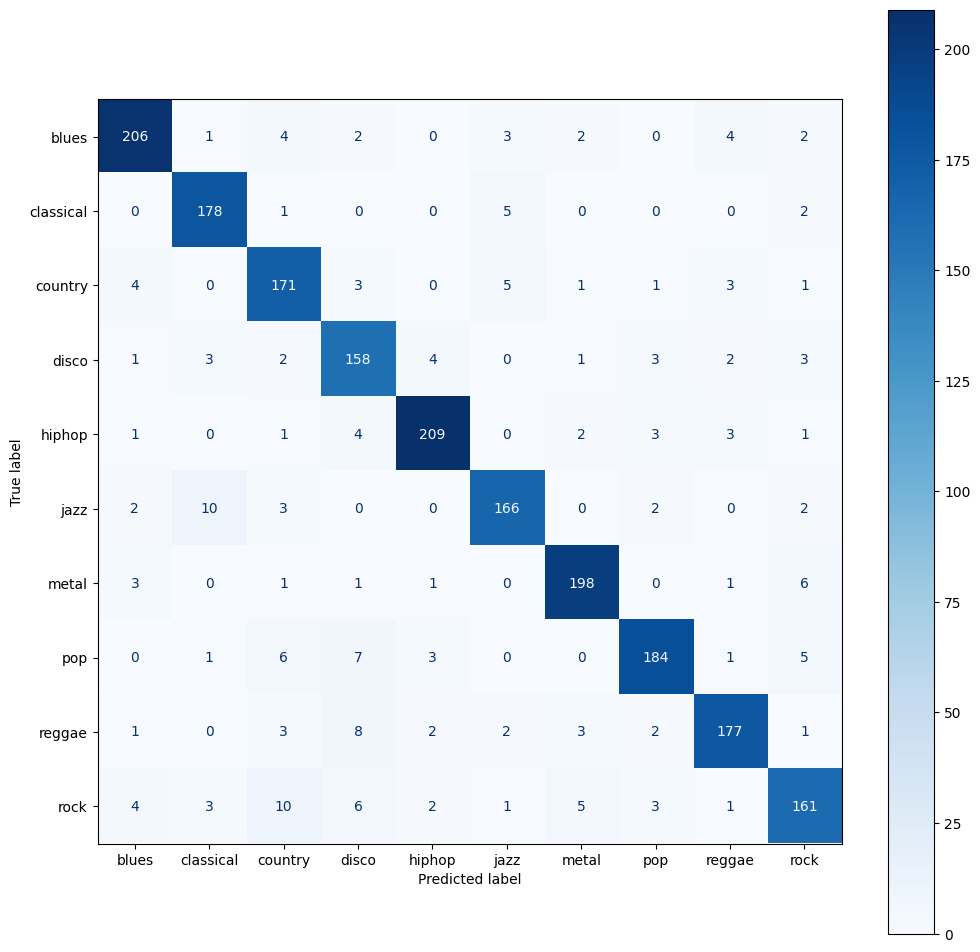

In [95]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train_sr, y_train)
hgbc_pred = hgbc.predict(X_test_sr)
print(f'Metrics for HistGradientBoostingClassifier:\n{get_metrics(y_test, hgbc_pred)}')

In [97]:
gs_hgbc = GridSearchCV(
    hgbc,
    param_grid={
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 0.1, 1.0]
},
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)
gs_hgbc.fit(X_train_sr, y_train)
gs_hgbc.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   4.7s
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   4.7s
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   4.7s
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   4.8s
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   4.8s
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   5.2s
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   5.3s
[CV] END l2_regularization=0.0, learning_rate=0.01, max_depth=None, max_iter=100, m

{'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'max_depth': None,
 'max_iter': 200,
 'min_samples_leaf': 50}

Metrics for HistGradientBoostingClassifier:
Accuracy: 0.9229229229229229
Precision: 0.92356671811569
Recall: 0.9229229229229229
F1: 0.9227344241658166
Confusion Matrix:


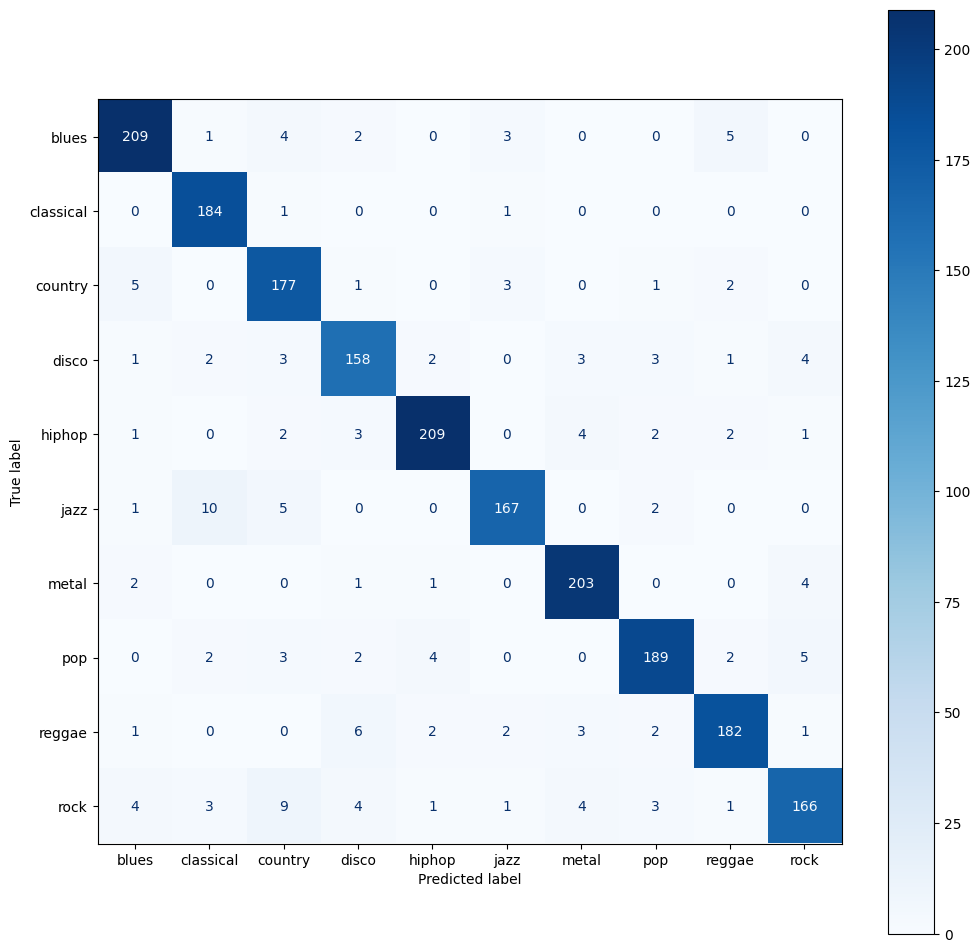

In [98]:
hgbc_bp = HistGradientBoostingClassifier(l2_regularization=0.0,
                                         learning_rate=0.1,
                                         max_depth=None,
                                         max_iter=200,
                                         min_samples_leaf=50)
hgbc_bp.fit(X_train_sr, y_train)
hgbc_bp_pred = hgbc_bp.predict(X_test_sr)
print(f'Metrics for HistGradientBoostingClassifier:\n{get_metrics(y_test, hgbc_bp_pred)}')

---

## Voting Classifier

Metrics for VotingClassifier:
Accuracy: 0.9354354354354354
Precision: 0.936292391857206
Recall: 0.9354354354354354
F1: 0.9354520321275757
Confusion Matrix:


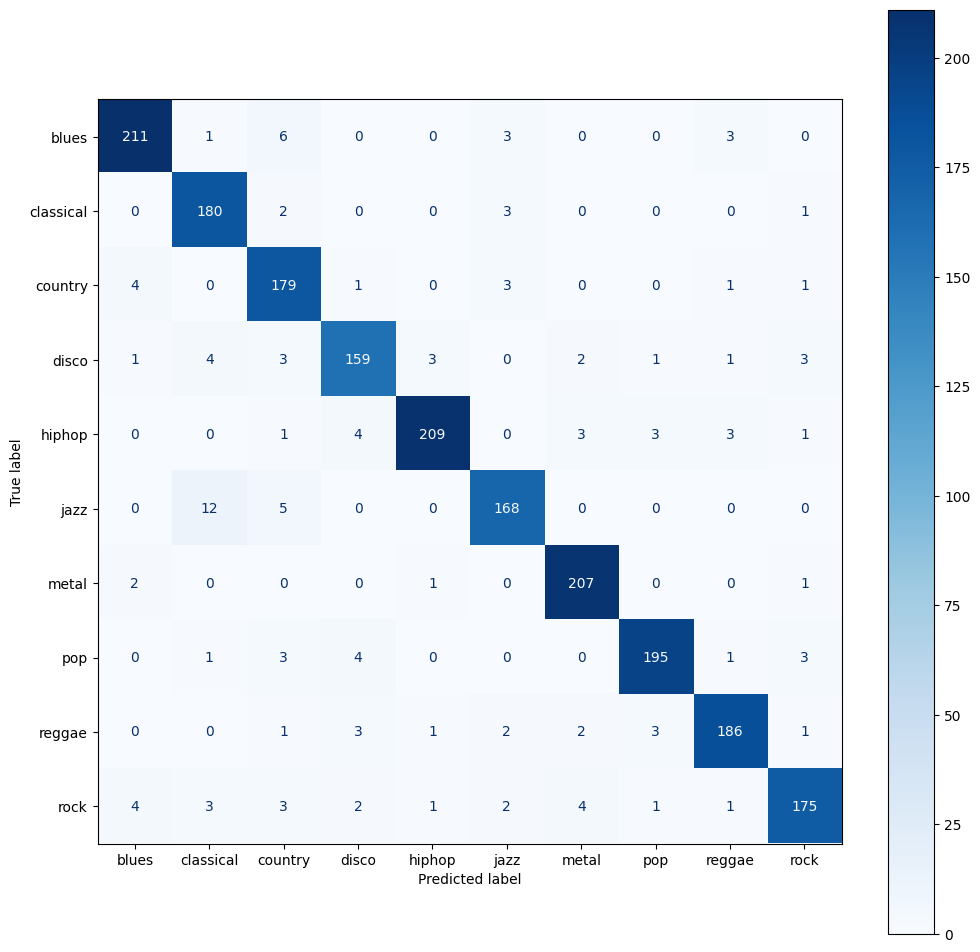

In [103]:
svm_bp_prob = SVC(C=21, gamma='auto', kernel='rbf', probability=True)
vc = VotingClassifier(estimators=[
    ('rf', rf_reduced),
    ('knn', knn_bp),
    ('gnb', gnb),
    ('lr', lr_bp),
    ('lda', lda_bp),
    ('qda', qda_bp),
    ('hgbc', hgbc_bp),
    ('svm', svm_bp_prob)
], weights=[2,2,1,1,1,1,2,2], voting='soft')
vc.fit(X_train_sr, y_train)
vc_pred = vc.predict(X_test_sr)
print(f'Metrics for VotingClassifier:\n{get_metrics(y_test, vc_pred)}')